In [1]:
import os
import PIL
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import requests
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tqdm import trange,tqdm
import warnings
from matplotlib.pyplot import figure

warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
# download weizmann horse dataset
URL = 'https://www.msri.org/people/members/eranb/weizmann_horse_db.tar.gz'
response = requests.get(URL)
open('weizmann_horse_db.tar.gz', 'wb').write(response.content)
with tarfile.open('weizmann_horse_db.tar.gz', "r:gz") as cur_tar:
    cur_tar.extractall(os.getcwd())
os.remove('weizmann_horse_db.tar.gz')

In [3]:
# read samples
dir_samples = os.getcwd()+"/weizmann_horse_db/rgb"
filelist_samples = []
for file in os.listdir(dir_samples):
    filelist_samples.append(os.fsdecode(file))
filelist_samples = sorted(filelist_samples)

X = []
for f in filelist_samples:
    X.append(torchvision.io.read_image(os.getcwd()+'/weizmann_horse_db/rgb/'+f))
    
# read labels
dir_samples = os.getcwd()+"/weizmann_horse_db/figure_ground"
filelist_samples = []
for file in os.listdir(dir_samples):
    filelist_samples.append(os.fsdecode(file))
filelist_samples = sorted(filelist_samples)

Y = []
for f in filelist_samples:
    im = torchvision.io.read_image(os.getcwd()+'/weizmann_horse_db/figure_ground/'+f)
    Y.append(im)

In [4]:
# interpolate all the data to required sizes

# input to 572x572, output to 388x388
for i in trange(len(X)):
    X[i] = F.interpolate(X[i].reshape((1,X[i].shape[0],X[i].shape[1],X[i].shape[2])),(572,572))
    Y[i] = F.interpolate(Y[i].reshape((1,Y[i].shape[0],Y[i].shape[1],Y[i].shape[2])),(388,388))
    
# split into train and val
Xt = X[:300]
Yt = Y[:300]
Xv = X[300:]
Yv = Y[300:]

100%|██████████| 328/328 [00:00<00:00, 463.16it/s]


In [5]:
# Unet model source: https://amaarora.github.io/2020/09/13/unet.html


class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

class Encoder(nn.Module):
    def __init__(self, chs=(3,32,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs
    
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.sig = nn.Sigmoid()

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return self.sig(out)

In [6]:
# train loop

unet = UNet().to(device)
epochs = 1500
lr = 5e-4;
optimizer = torch.optim.Adam(params=unet.parameters(),lr=lr)
losses_t = []
losses_v = []
loss_fcn = nn.BCELoss()
BS = 16
disable_val = True
sig = F.sigmoid

for epoch in (t:=trange(epochs)):
    samp = np.random.randint(0,len(Xt),(BS))
    # train over minibatch
    with torch.enable_grad():
        loss_t = 0
        for i in samp:
            out = unet(Xt[i].float().to(device))
            target = Yt[i].float()
            # s = target
            # plt.imshow(s.to('cpu').detach().numpy().reshape(s.shape[1:]).transpose((1,2,0)).squeeze(),cmap='gray')
            # plt.show()
            target = torch.where(target > 125, torch.ones(target.shape), torch.zeros(target.shape)).to(device)
            loss_t += loss_fcn(out,target)/BS
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
    if not disable_val:
        with torch.no_grad():
            loss_v = 0
            for i in range(len(Xv)):
                out = unet(Xv[i].float().to(device)) 
                target = Yv[i].float()
                target = torch.where(target > 125, torch.ones(target.shape), torch.zeros(target.shape)).to(device)
                loss_v += loss_fcn(out,target)/len(Xv)
    # dynamically change learning rate
    if epoch == 30:
         for g in optimizer.param_groups:
                lr = 1e-3
                g['lr'] = lr
        
    # record losses
    losses_t.append(loss_t.item())
    if not disable_val:
        losses_v.append(loss_v.item())
    # set tqdm description
    if not disable_val:
        t.set_description("train loss %.2f, val loss %.2f" % (loss_t.item(),loss_v.item()))
    else:
        t.set_description("train loss %.2f" % (loss_t.item()))

train loss 0.07: 100%|██████████| 1500/1500 [09:57<00:00,  2.51it/s]


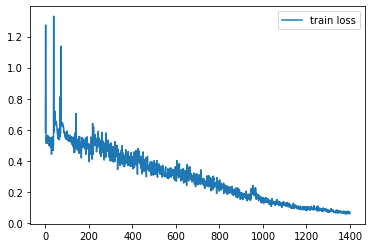

In [7]:
if not disable_val:
    plt.plot(losses_t[100:], label='train loss')
    plt.plot(losses_v[100:], label='val loss')
    plt.legend()
else:
    plt.plot(losses_t[100:], label='train loss')
    plt.legend()

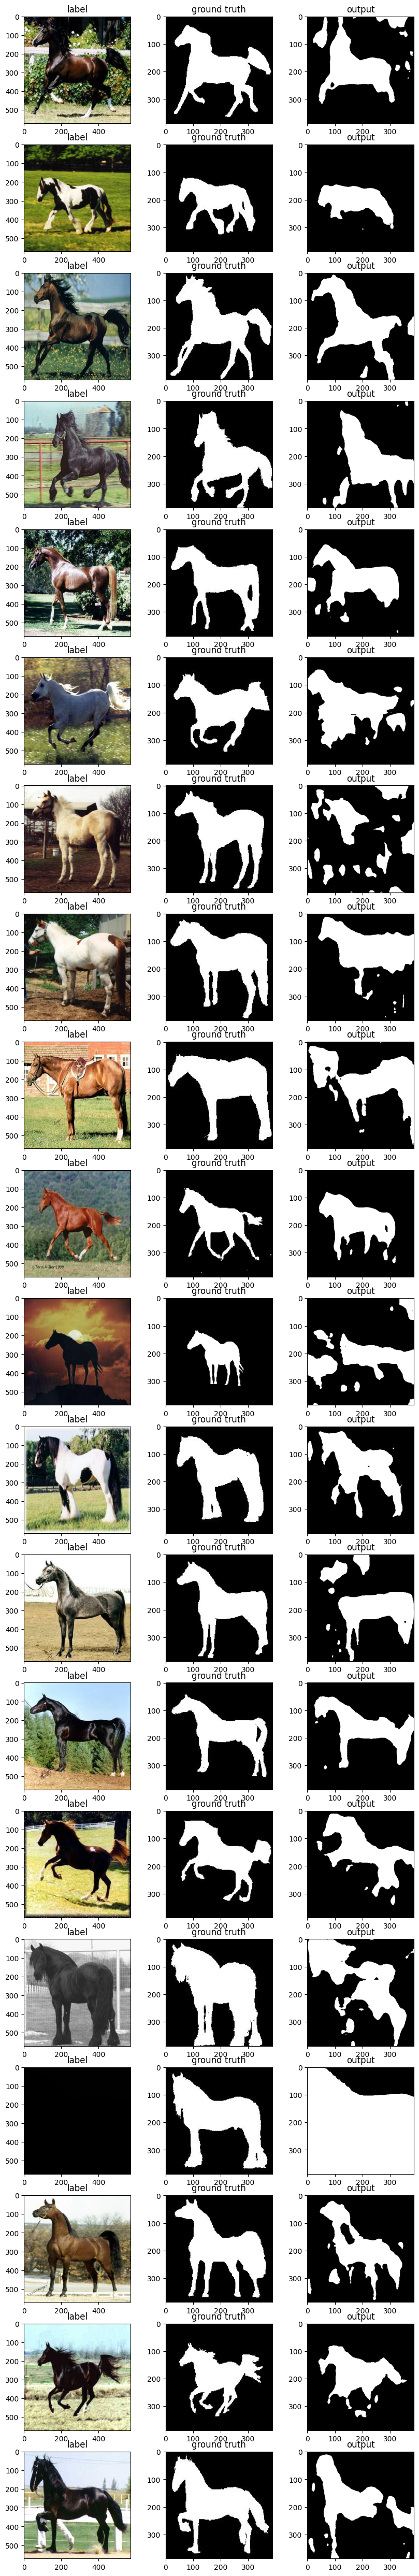

In [8]:
# plot specific images from validation dataset

idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # indices of val images to be plotted
nimg = len(idx)
f,axarr = plt.subplots(nimg,3,figsize=(10,65), dpi=100)

for i in idx:
    l = unet(Xv[i].float().to(device))
    img1 = Xv[i].to('cpu').numpy().reshape(Xv[i].shape[1:]).transpose((1,2,0))
    img2 = Yv[i].to('cpu').numpy().reshape(Yv[i].shape[1:]).transpose((1,2,0))
    img3 = l.to('cpu').detach()
    img3 = torch.where(img3>0.5,255*torch.ones(img3.shape),torch.zeros(img3.shape))
    img3 = img3.numpy().reshape(l.shape[1:]).transpose((1,2,0))

    # plot label
    axarr[i-1,0].imshow(img1)
    axarr[i-1,0].title.set_text('label')

    # plot label
    axarr[i-1,1].imshow(img2.squeeze(),cmap='gray')
    axarr[i-1,1].title.set_text('ground truth')

    # plot label
    axarr[i-1,2].imshow(img3.squeeze(),cmap='gray')
    axarr[i-1,2].title.set_text('output')